In [ ]:
import os
import cv2
import numpy as np

# Define the path to the dataset folder
data_path = 'asl_alphabet_train'

# Define the target image size
img_size = (224, 224)

# Define the function for preprocessing images
def preprocess_image(img_path):
    # Load the image
    img = cv2.imread(img_path)
    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize to target size
    img = cv2.resize(img, img_size)
    # Convert to float32 and normalize to [0, 1] range
    img = img.astype(np.float32) / 255.0
    # Add channel dimension for compatibility with deep learning models
    img = np.expand_dims(img, axis=-1)
    return img

# Iterate over all subfolders (each representing a different sign language letter)
for subdir in os.listdir(data_path):
    # Iterate over all image files in the subfolder
    i=1;
    for file in os.listdir(os.path.join(data_path, subdir)):
        # Preprocess the image and save it to a new file
        img_path = os.path.join(data_path, subdir, file)
        img = preprocess_image(img_path)
        save_path = os.path.join('asl_alphabet_train_processed', subdir, file)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, img)
        i+=1
        if(i==1000):
            break


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the path to the preprocessed dataset folder
data_path = 'asl_alphabet_train_processed'

# Define the batch size and number of epochs for training
batch_size = 128
epochs = 50

# Load the preprocessed image data and labels
X = []
y = []
for subdir in os.listdir(data_path):
    label = ord(subdir) - ord('A')
    img_paths = [os.path.join(data_path, subdir, file) for file in os.listdir(os.path.join(data_path, subdir))]
    imgs = [np.load(img_path) for img_path in img_paths]
    X.extend(imgs)
    y.extend([label] * len(imgs))
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))



Epoch 1/50
 11/163 [=>............................] - ETA: 23:06 - loss: 3.2809 - accuracy: 0.0426

In [ ]:
from tensorflow.keras.models import load_model

# save the model
model.save('model.h5')

# load the saved model
loaded_model = load_model('model.h5')


In [ ]:
train_accuracy = model.history['accuracy']
val_accuracy = model.history['val_accuracy']

train_loss = model.history['loss']
val_loss = model.history['val_loss']

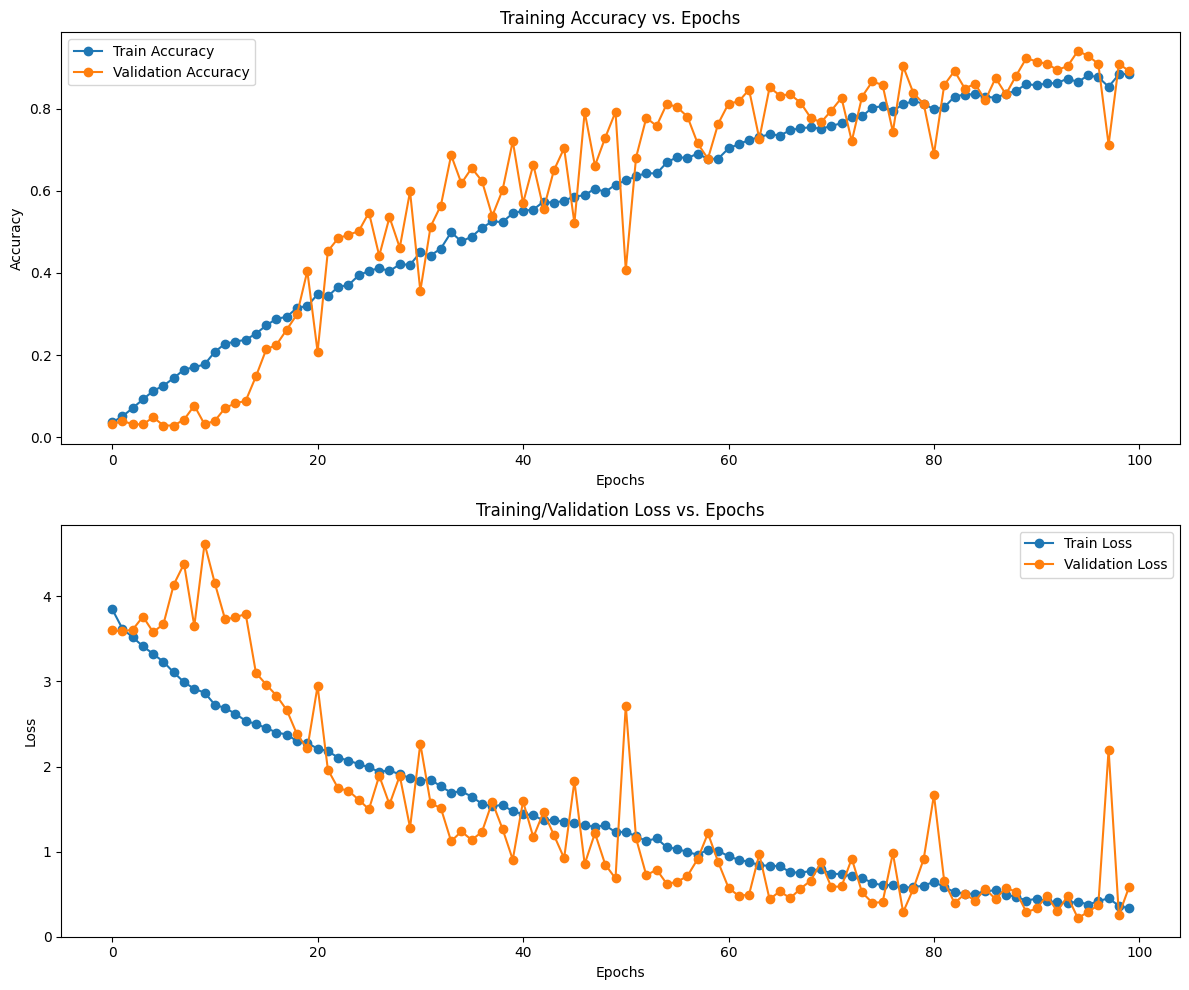

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
test = tf.keras.utils.image_dataset_from_directory('test')

Found 359 files belonging to 36 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory('asl_alphabet_test',
                                                 shuffle=False,
                                                 batch_size=batch_size,
                                                 target_size = (224, 224),
                                                 class_mode='categorical')

Found 359 images belonging to 36 classes.


In [ ]:
predictions = model.predict(test_generator)

3/3 [==============================] - 14s 5s/step


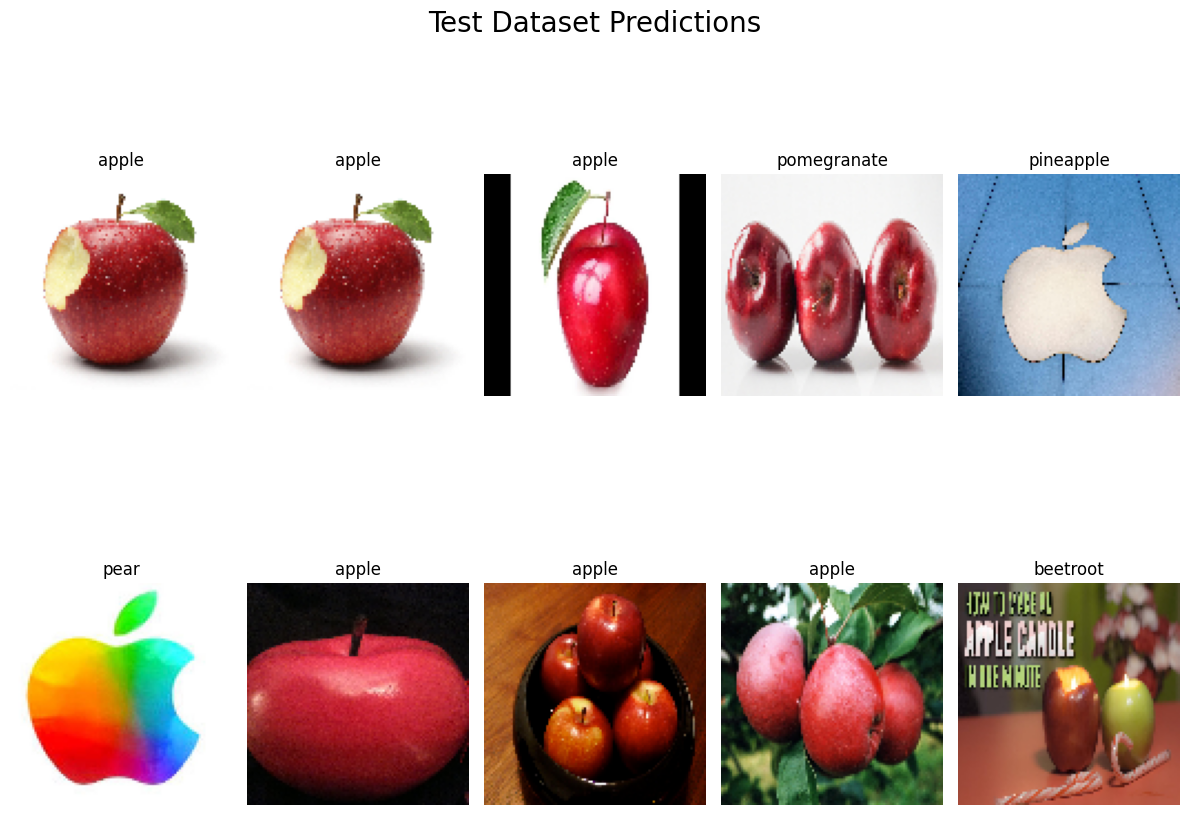

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
import os

# Define the path to the dataset directory
data_dir = 'asl_alphabet_train_processed'

# Loop over the files in the directory
for file_name in os.listdir(data_dir):
    # Check if the file is a .DS_Store file
    if file_name == '.DS_Store':
        # Delete the file
        os.remove(os.path.join(data_dir, file_name))
